In [14]:
import pandas as pd
import numpy as np
import nltk
import torch

# preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from transformers import BertTokenizer, BertModel


# metrics and test
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# others
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pickle



In [15]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import pandas as pd

df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ExtractionProject/train.txt',delimiter='\t',header=None)
df['language'] = df[0].str.extract(r'\((.*?)\)')
# df[0] = df[0].str.replace(r'\((.*?)\)', '')

df=df.rename( columns={0:'sentence'})
df['sentence'] = df['sentence'].str.slice(5)
df.head()

,sentence,language
0,IThe importance and popularity of travelling ...,GER
1,"It is an important decision , how to plan you...",TUR
2,Some people believe that young people can enj...,CHI
3,Travelling is usually considered as good recr...,TEL
4,i agree that . Life is a person live period o...,ARA


# EDA

## Calcul de certaines metrique interessantes

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

def average_sentence_length(sentences):
    #sentences = nltk.sent_tokenize(text)
    total_words = sum(len(word_tokenize(sent)) for sent in sentences)
    return total_words / len(sentences)

In [ ]:
df['sentence'] = df['sentence'].apply(lambda x : re.sub(r'\s+', ' ', x))
df['sentence_lowercase'] = df['sentence'].apply(lambda x : x.lower())
df['sentence_without_ponctuation'] = df['sentence'].str.replace('[{}]'.format(string.punctuation), '')

df['sentence_Tokenized'] = df['sentence'].apply(lambda x :  nltk.sent_tokenize(x))
df['words_Tokenized'] = df['sentence_without_ponctuation'].apply(lambda x :  nltk.word_tokenize(x))

df['sentence_count'] = df['sentence_Tokenized'].apply(lambda x: len(x))
df['word_count'] = df['words_Tokenized'].apply(lambda x : len(x))
df['avg_sentence_length'] = df['sentence_Tokenized'].apply(average_sentence_length)
df.head()

## Les mots les plus utilisés par langue

In [ ]:
stop_words = set(stopwords.words('english'))

def extract_top_words(text, n=10):
    words = word_tokenize(text.lower())
    filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
    word_counts = Counter(filtered_words)
    top_words = word_counts.most_common(n)
    return top_words

top_words_per_target = df.groupby('Language')['sentence'].apply(lambda x: extract_top_words(' '.join(x), n=10))
top_words_per_target

## Analyse des word-Ngram

In [ ]:
def get_ngrams(text, ngram_from=2, ngram_to=2, n=None, max_features=10):

    vec = CountVectorizer(ngram_range = (ngram_from, ngram_to),
                          max_features = max_features,
                          stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

    return words_freq[:n]

### Word Bigrams

In [ ]:
list = []
langs = df['Language'].unique().tolist()
for i in langs :
  # Bigrams
  bigrams = get_ngrams(df[df['Language'] == i]['sentence'], ngram_from=2, ngram_to=2, n=150)
  bigrams_df = pd.DataFrame(bigrams)
  bigrams_df.columns=["Bigram", "Frequency"]
  list.append(bigrams_df)
  fig = px.bar(list[langs.index(i)], x = 'Bigram', y = 'Frequency' , title=i)
  fig.show()

### Word Trigrams

In [ ]:
list = []
langs = df['Language'].unique().tolist()
for i in langs :
  # Bigrams
  bigrams = get_ngrams(df[df['Language'] == i]['sentence'], ngram_from=3, ngram_to=3, n=150)
  bigrams_df = pd.DataFrame(bigrams)
  bigrams_df.columns=["Bigram", "Frequency"]
  list.append(bigrams_df)
  fig = px.bar(list[langs.index(i)], x = 'Bigram', y = 'Frequency' , title=i)
  fig.show()


## Analyse des caracter Ngram

In [ ]:
def get_ngrams(text, ngram_from=2, ngram_to=2, n=None, max_features=10):

    vec = CountVectorizer(ngram_range = (ngram_from, ngram_to),
                          max_features = max_features,analyzer='char',
                          stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

    return words_freq[:n]

In [ ]:
list = []
langs = df['Language'].unique().tolist()

# On varie ce parametres selon le besoin il represente lke nb de caracter a ^prendre en compte
nb_char = 15

for i in langs :
  # Bigrams
  bigrams = get_ngrams(df[df['Language'] == i]['sentence'], ngram_from=nb_char, ngram_to=nb_char, n=150)
  bigrams_df = pd.DataFrame(bigrams)
  bigrams_df.columns=["Bigram", "Frequency"]
  list.append(bigrams_df)
  fig = px.bar(list[langs.index(i)], x = 'Bigram', y = 'Frequency' , title=i)
  fig.show()


## Longeurs des phrases par langue

In [ ]:
# Calculer le word count moyen par langue
avg_word_count_by_language = df.groupby('Language')['word_count'].mean()

# Affichage du diagramme à barres
plt.figure(figsize=(10, 6))
avg_word_count_by_language.plot(kind='bar', color='skyblue')
plt.title('Nb de mots moyen de mots par langue')
plt.xlabel('Langue')
plt.ylabel('Nb de mots moyen')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Longeur de phrase moyenne par langue

In [ ]:
# Calculer le word count moyen par langue
avg_word_count_by_language = df.groupby('Language')['avg_sentence_length'].mean()

# Affichage du diagramme à barres
plt.figure(figsize=(10, 6))
avg_word_count_by_language.plot(kind='bar', color='skyblue')
plt.title('longueur de phrase moyenne par langue')
plt.xlabel('Langue')
plt.ylabel('longeur de phrase moyenne')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Erreur communes a chaque langue

In [ ]:
from languagetool import LanguageTool

def get_common_errors_with_context(text, language_tool):
    # check le text
    matches = language_tool.check(text)
    errors = [(match.message, text[max(0, match.offset - 10):match.offset + match.errorLength + 10]) for match in matches]
    errors = [(error, context.strip()) for error, context in errors if context.strip() and any(char.isalpha() for char in context)]

    return errors

language_tool = LanguageTool("en-US")

common_errors_dict = {}

for lang in df['language'].unique():
    lang_df = df[df['language'] == lang]
    common_errors = Counter()
    # on boucle sur les ^phrase de chaque langue
    for sentence in lang_df['sentence']:
        errors = get_common_errors_with_context(sentence, language_tool)
        common_errors.update(errors)
    # on garde les 10 plus frequente
    common_errors_dict[lang] = common_errors.most_common(10)

for lang, errors in common_errors_dict.items():
    print(f"10 Most Common Errors in {lang}:")
    for (error, context), count in errors:
        print(f"- '{context}' - Error: {error} (Count: {count})")
    print()


# Test des approches de preprocessing

## Bag Of Words

In [8]:
text = df['sentence_lowercase']
model = CountVectorizer(ngram_range = (1, 1), stop_words='english')
matrix = model.fit_transform(text).toarray()

df_countVec = pd.DataFrame(data = matrix, columns = model.get_feature_names_out())

# vectorisation + data split
vectorizer = CountVectorizer(max_features = 1000, min_df = 0.1, stop_words='english')
X = df['sentence_lowercase'].values
X = vectorizer.fit_transform(X)
print(type(X))
y = df['Language'].values

In [ ]:
models = [SVC(), LogisticRegression(), RandomForestClassifier()]
models_names = ["SVC", "Logistic Regression", "Random Forest" ]
bow_mean_scores = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for clf in models :
  scores = cross_val_score(clf, X, y, cv = cv, scoring='accuracy')
  bow_mean_scores.append(scores.mean())
  print("**", models_names[models.index(clf)], "**")
  print("Scores: ", scores)
  print("Average Score: ", scores.mean())
  print('************************************')

## TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(max_features = 10000, stop_words='english')
X = df['sentence_lowercase'].values
X = vectorizer.fit_transform(X)
y = df['Language'].values

# entrainement des modeles sur ces données vectorisées
models = [SVC(), LogisticRegression(), RandomForestClassifier()]
models_names = ["SVC", "Logistic Regression", "Random Forest" ]
tf_mean_scores = []
for clf in models :
  scores = cross_val_score(clf, X, y, cv = cv, scoring='accuracy')
  tf_mean_scores.append(scores.mean())
  print("**", models_names[models.index(clf)], "**")
  print("Scores: ", scores)
  print("Average Score: ", scores.mean())
  print('************************************')

# Modeles Simples sur texte brute (avec TF-IDF)

In [ ]:
X = df['sentence']
y = df['language']

# Définir les pipelines pour chaque modèle
pipelines = {
    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ]),
    'SVM': Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', SVC())
    ]),
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression())
    ]),
    'Random Forest': Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', RandomForestClassifier())
    ])
}


param_grids = {
    'Naive Bayes': {
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__alpha': [0.1, 0.5, 1.0]
    },
    'SVM': {
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__C': [1, 10, 100],
        'clf__kernel': ['linear', 'rbf']
    },
    'Logistic Regression': {
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__C': [0.1, 1, 10]
    },
    'Random Forest': {
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [None, 10, 20]
    }
}


X_train, X_test, y_train, y_test = train_test_split(df['sentence'], df['language'], test_size=0.2, stratify=y )

# gridSearch with cross validation and testing on y_test
for model_name, pipeline in pipelines.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best parameters found:")
    print(grid_search.best_params_)
    print("Best cross-validation score:")
    print(grid_search.best_score_)
    print("Classification report on test set:")
    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("="*50)


# Ensemble classifier

## SVC linear + SVC rbf + Logistic Regression

Ensemble Accuracy: 0.6843434343434344
[[106   5   5   6  14   3   7   4   4   5  11]
 [  5 119   5   3   4   1  11  13   7   1   6]
 [  6   4 135   5   6  13   4   4   8   1   7]
 [  1   0   7 139   2  10   0   2   6   1   4]
 [  3   4   1   3 131   0   2   1   2  25   4]
 [  5   5  16   3   2 117   2   1  10   3   0]
 [  6  14   1   2   0   1 123  29   6   0   4]
 [  4  19   2   4   5   1  28 121   5   3   9]
 [ 11   3  10   6   9  18   2   3 124   1   9]
 [  1   1   0   1  39   0   2   0   2 131   2]
 [ 13   7   4   4   7   6   5   8   4   1 109]]


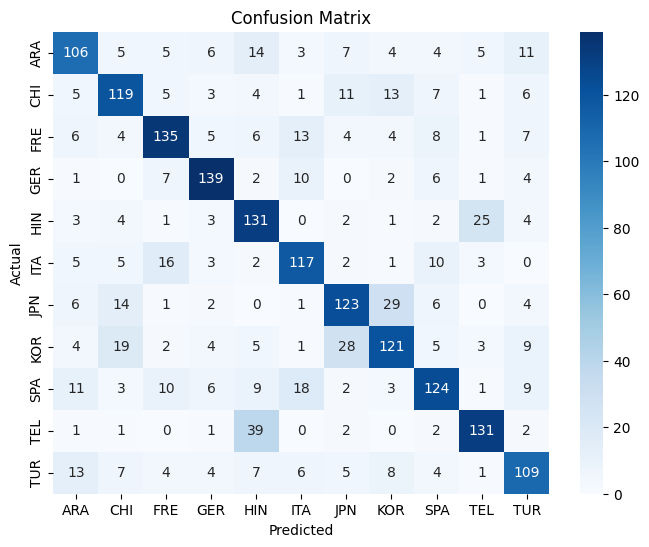

In [16]:
X = df['sentence']
y = df['language']

# vectorisation et split
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# definition de 03 classfieurs simples
svm_clf = SVC(kernel='linear', probability=True)
svm_rbf_clf = SVC(kernel='rbf')
lr_clf = LogisticRegression(max_iter=1000)

# creation de l'ensemble avec une politique de vote
ensemble_clf = VotingClassifier(estimators=[('svm', svm_clf), ('svm-rbf', svm_rbf_clf), ('lr', lr_clf)], voting='hard')
ensemble_clf.fit(X_train, y_train)
y_pred = ensemble_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Ensemble Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred)
print (cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=ensemble_clf.classes_, yticklabels=ensemble_clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ARA       0.66      0.62      0.64       170
         CHI       0.66      0.68      0.67       175
         FRE       0.73      0.70      0.71       193
         GER       0.79      0.81      0.80       172
         HIN       0.60      0.74      0.66       176
         ITA       0.69      0.71      0.70       164
         JPN       0.66      0.66      0.66       186
         KOR       0.65      0.60      0.63       201
         SPA       0.70      0.63      0.66       196
         TEL       0.76      0.73      0.75       179
         TUR       0.66      0.65      0.65       168

    accuracy                           0.68      1980
   macro avg       0.69      0.69      0.68      1980
weighted avg       0.69      0.68      0.68      1980



## Bagging classifier (avec des instances du meme model)

In [ ]:
X = df['sentence']
y = df['language']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

svm_classifier = SVC(kernel='linear')

ensemble_classifier = BaggingClassifier(base_estimator=svm_classifier, n_estimators=10, random_state=42)
ensemble_classifier.fit(X_train_vectorized, y_train)

predictions = ensemble_classifier.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.6863636363636364


Confusion Matrix:
[[112   5   6   6  14   2   6   3   4   6   6]
 [  5 126   5   4   5   0   8  11   6   1   4]
 [  7   5 151   2   3   7   3   3   6   0   6]
 [  0   1   8 142   2   7   0   2   5   2   3]
 [  4   4   1   5 133   0   1   0   2  22   4]
 [  4   4  18   5   3 117   2   1   8   2   0]
 [  8  16   3   2   0   3 120  28   3   0   3]
 [  7  21   3   5   3   3  28 117   5   3   6]
 [ 14   2  13  12   8  20   0   3 117   0   7]
 [  2   2   0   2  42   0   2   0   1 126   2]
 [ 13   8   4   5   6   8   4   8   6   3 103]]


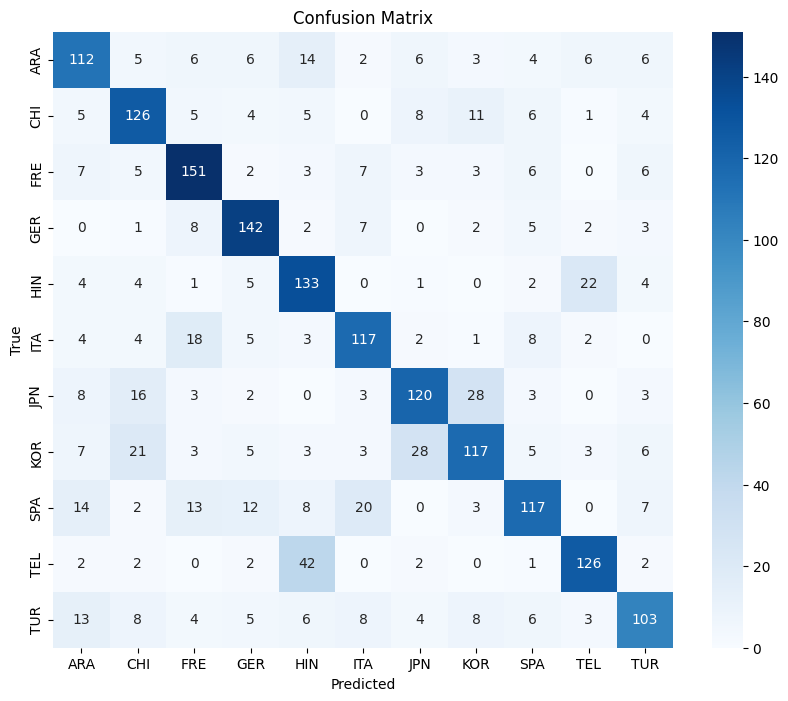

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ensemble_classifier.classes_, yticklabels=ensemble_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Ensemble de svm (chaque instance avec des features differrentes)

In [ ]:

# Split the data into features (X) and target label (y)
X = df['sentence']
y = df['language']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature extraction for Word/Lemma 1to2-grams
word_lemma_vectorizer = TfidfVectorizer(ngram_range=(1, 2), analyzer='word')
X_train_word_lemma = word_lemma_vectorizer.fit_transform(X_train)
X_test_word_lemma = word_lemma_vectorizer.transform(X_test)

# Feature extraction for Character 1to3-grams
char_vectorizer = TfidfVectorizer(ngram_range=(1, 3), analyzer='char')
X_train_char = char_vectorizer.fit_transform(X_train)
X_test_char = char_vectorizer.transform(X_test)

# Feature extraction for Function word unigrams
function_word_vectorizer = TfidfVectorizer(ngram_range=(1, 1), analyzer='word', stop_words='english')
X_train_func_word = function_word_vectorizer.fit_transform(X_train)
X_test_func_word = function_word_vectorizer.transform(X_test)

# Feature extraction for Function word bigrams
function_word_bigram_vectorizer = TfidfVectorizer(ngram_range=(2, 2), analyzer='word', stop_words='english')
X_train_func_word_bigram = function_word_bigram_vectorizer.fit_transform(X_train)
X_test_func_word_bigram = function_word_bigram_vectorizer.transform(X_test)


# Initialize SVM classifiers with different feature sets
svm_word_lemma = SVC(kernel='linear')
svm_char = SVC(kernel='linear')
svm_func_word = SVC(kernel='linear')
svm_func_word_bigram = SVC(kernel='linear')
svm_pos = SVC(kernel='linear')

# Train the SVM classifiers
svm_word_lemma.fit(X_train_word_lemma, y_train)
svm_char.fit(X_train_char, y_train)
svm_func_word.fit(X_train_func_word, y_train)
svm_func_word_bigram.fit(X_train_func_word_bigram, y_train)

# Make predictions on the test data
pred_word_lemma = svm_word_lemma.predict(X_test_word_lemma)
pred_char = svm_char.predict(X_test_char)
pred_func_word = svm_func_word.predict(X_test_func_word)
pred_func_word_bigram = svm_func_word_bigram.predict(X_test_func_word_bigram)

ensemble_pred = pd.DataFrame({'word_lemma': pred_word_lemma, 'char': pred_char,
                              'func_word': pred_func_word, 'func_word_bigram': pred_func_word_bigram})

ensemble_pred['voted'] = ensemble_pred.mode(axis=1)[0]

accuracy = accuracy_score(y_test, ensemble_pred['voted'])
print("Ensemble Accuracy:", accuracy)


# ** Modele Hierachique - utilisé lors de l'examen**

## Predire groupe de langue

### Recherche des meilleurs parametres

In [ ]:
# Définir les groupes de langues
language_groups = {
    'Romance': ['ITA', 'FRE', 'SPA'],
    'Indian': ['HIN', 'TEL'],
    'Arabic': ['ARA'],
    'Turkish': ['TUR'],
    'Asian': ['CHI', 'JPN', 'KOR'],
    'German': ['GER']
}

# Étape 1: Classification des groupes de langues
def classify_language_group(lang):
    for group, languages in language_groups.items():
        if lang in languages:
            return group

df['language_group'] = df['language'].apply(classify_language_group)

# Division des données en ensembles de formation et de test
X_train, X_test, y_train, y_test = train_test_split(df['sentence'], df['language_group'], test_size=0.2, random_state=42)

# Vectorisation des données textuelles
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Définition des paramètres à rechercher
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear']
}

# Initialisation de GridSearchCV
svm_grid_search = GridSearchCV(SVC(), param_grid, cv=5)

# Recherche des meilleurs paramètres
svm_grid_search.fit(X_train_vec, y_train)

# Meilleurs paramètres trouvés
best_params = svm_grid_search.best_params_
print("Meilleurs paramètres trouvés:", best_params)

# Évaluation du modèle avec les meilleurs paramètres
y_pred = svm_grid_search.predict(X_test_vec)
print(classification_report(y_test, y_pred))


### Entrainement du bon modele

In [ ]:
# Définir les groupes de langues
language_groups = {
    'Romance': ['ITA', 'FRE', 'SPA'],
    'Indian': ['HIN', 'TEL'],
    'Arabic': ['ARA'],
    'Turkish': ['TUR'],
    'Asian': ['CHI', 'JPN', 'KOR'],
    'German': ['GER']
}

# Étape 1: Classification des groupes de langues
def classify_language_group(lang):
    for group, languages in language_groups.items():
        if lang in languages:
            return group

df['language_group'] = df['language'].apply(classify_language_group)

# Division des données en ensembles de formation et de test
X_train, X_test, y_train, y_test = train_test_split(df['sentence'], df['language_group'], test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(df['sentence'], df['language_group'], test_size=0.2, random_state=42, stratify=df['language_group'])

# Vectorisation des données textuelles
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Entrainement du modèle SVM
svm_model = SVC(kernel='linear', c=0.1)
svm_model.fit(X_train_vec, y_train)

# Évaluation du modèle
y_pred = svm_model.predict(X_test_vec)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

      Arabic       0.90      0.50      0.64       170
       Asian       0.87      0.93      0.90       562
      German       0.89      0.79      0.84       172
      Indian       0.90      0.97      0.93       355
     Romance       0.81      0.93      0.87       553
     Turkish       0.92      0.65      0.76       168

    accuracy                           0.86      1980
   macro avg       0.88      0.80      0.82      1980
weighted avg       0.87      0.86      0.86      1980



In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/ExtractionProject/svm_predict_group_final.pkl'

# Save the model to file
with open(file_path, 'wb') as file:
    pickle.dump(svm_model, file)

## Prediction langue dans groupe

In [ ]:
# Création d'un dictionnaire pour stocker les modèles par groupe de langue
models = {}
filtered_language_groups = {
    'Romance': ['ITA', 'FRE', 'SPA'],
    'Indian': ['HIN', 'TEL'],
    'Asian': ['CHI', 'JPN', 'KOR'],
}

# Entraîner un modèle pour chaque groupe de langue
for group, languages in filtered_language_groups.items():
    # Filtrer les données pour le groupe de langue
    group_data = df[df['language_group'] == group]


    # Vectoriser les données textuelles
    vectorizer = TfidfVectorizer(ngram_range=(1, 2))
    X_train_group_vec = vectorizer.fit_transform(group_data['sentence'])

    # Entraîner le modèle SVM
    svm_model = SVC(kernel='linear')
    svm_model.fit(X_train_group_vec, group_data['language'])

    # Stocker le modèle et le vectorizer dans le dictionnaire
    models[group] = {'model': svm_model, 'vectorizer': vectorizer}

# Fonction pour prédire la langue du texte
def predict_language(sentence):
    # Prédire le groupe de langue du texte
    group = classify_language_group(svm_model.predict(vectorizer.transform([sentence]))[0])
    if group == 'Arabic' :
      language == 'ARA'
    elif group == 'Turkish' :
      language == 'TUR'
    elif group == 'German' :
      language == 'GER'
    # Utiliser le modèle correspondant pour prédire la langue réelle du texte
    language = models[group]['model'].predict(models[group]['vectorizer'].transform([sentence]))[0]

    return language



## NB : Utilisation du modele

### lecture du fichier examen

In [ ]:
exam = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ExtractionProject/test.txt',delimiter='\t',header=None)
exam = exam.rename( columns={0:'sentence'})
exam

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
vectorizer.fit(df['sentence'])
exam_vec = vectorizer.transform(exam['sentence'])

Pour des soucis de temps d'execution nous avons enregistré le premier modele qui prédis le groupe de langue, et dans la cellule qui suit on le load

In [11]:

# Define the file path where your model is saved
file_path = '/content/drive/MyDrive/Colab Notebooks/ExtractionProject/svm_predict_group_final.pkl'

# Load the model from file
with open(file_path, 'rb') as file:
    loaded_model = pickle.load(file)


* La on prédis le groupe de langue de chaque essay

In [ ]:
exam['group'] = loaded_model.predict(exam_vec)
exam['group']

* La on predis dans chaque groupe la langue de chaque essay avec les modeles spécifiques preentrainés précedemment

In [ ]:
exam['langage_predicted'] = exam['sentence'].apply(predict_language)
exam['langage_predicted']

# LLM

## BERT

In [ ]:
# Chargement du BERT tokenizer et du model pre-entrainé
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')

input_text = df['sentence'].tolist()
input_ids = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True)['input_ids']

with torch.no_grad():
    outputs = model(input_ids)
    embeddings = outputs.last_hidden_state

sentence_embeddings = torch.mean(embeddings, dim=1)

X = sentence_embeddings.numpy()
y = df['Language']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
